In [ ]:
!pip install -U langgraph langchain-community langchain-anthropic tavily-python pandas openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.4/720.4 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing

In [ ]:
!pip install langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
from langchain_groq import ChatGroq
import requests
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState
# from langchain_ollama import ChatOllama
from typing import Annotated
from datetime import datetime, date
from toolsAgent import find_customer, make_order, get_products, fund_customer
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict
from langchain_core.messages import  HumanMessage,AIMessage

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    tool_query: str
    next: str
    customer_verified: bool
    customer_name: str
    customer_id: str



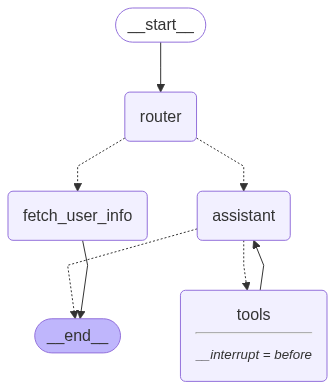

In [ ]:
def handle_tool_error(state) -> dict:
    error = state.get("error")
    print("🔴 TOOL ERROR:", error)
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )



from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,START, END
from langgraph.prebuilt import tools_condition
from langchain_core.runnables import Runnable ,RunnableConfig



class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        try:
            # Check if customer was just verified and add a welcome message
            if state.get("customer_verified") and len(state["messages"]) > 0:
                print("Customer verified, adding welcome message")
                last_message = state["messages"][-1]
                if not (hasattr(last_message, "content") and "verified" in str(last_message.content).lower()):
                    # Add a transition message after verification
                    welcome_msg = AIMessage(
                        content=f"Thank you for verifying your identity, {state.get('customer_name', '')}! How can I assist you today? You can ask about our products or place an order."
                    )
                    state = {**state, "messages": state["messages"] + [welcome_msg]}

            # Invoke the runnable with the current state
            result = self.runnable.invoke(state)

            # Handle empty responses
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [HumanMessage(content="Respond with a real output.")]
                state = {**state, "messages": messages}
                result = self.runnable.invoke(state)

            print("result", result)
            return {"messages": result}
        except Exception as e:
            print(f"Error in Assistant: {str(e)}")
            error_msg = AIMessage(content="I apologize, but I encountered an issue. How can I help you today?")
            return {"messages": error_msg}



local_llm = "llama3-70b-8192"
llm =ChatGroq(model=local_llm,groq_api_key="" ,temperature=0.7,max_retries=2)
companyName = "GoutamSAchdev"
try:
    response = requests.get('http://localhost:5000/productlines')
    if response.status_code == 200:
        product_categories = [item['productLine'] for item in response.json()]
    else:
        product_categories = []
except requests.RequestException as e:

    product_categories = []
primary_assistant_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        f"""
You are a friendly and helpful Sales Agent named John Doe at our {companyName} company.
Begin by warmly welcoming the customer and introducing yourself.
Always remember do not make assumptions.
Let them know the product categories we currently offer: {', '.join(product_categories) if product_categories else 'None available at the moment'}.
Ask the customer which category they're interested in.

Once they select a category, use the 'get_products' tool to retrieve available products in that category.
Help the customer by describing a few options briefly. Don't list all products at once — just mention a couple at first.
If the customer doesn't like those, offer a few different ones from the same category.

Guide the customer through selecting a product.
Once a selection is made, use the 'make_order' tool to process their order with:
- The product name they selected
- The quantity they want to order

IMPORTANT:
- Be conversational and helpful.
- Do not overwhelm the customer with too many options at once.
- Focus on making the process smooth and friendly.
- Always confirm the order details before processing.
- Do not make assumptions; all product details come from the get_products tool.
Please do not use any formatting symbols like asterisks. Just reply with plain text, no Markdown or special characters.

        """
    ),
    ("placeholder", "{messages}"),
]).partial(time=datetime.now(), date=date.today(), day=datetime.today().strftime("%A"))
# vector_store, _, _ = load_all_vsl(1)
#     docs =  vector_store.as_retriever(search_kwargs={"k": 3}).get_relevant_documents(query)
#     context = "\n".join([doc.page_content for doc in docs])
#     return {"query": query, "context": context}

part_1_tools = [
    make_order,get_products
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools )



builder = StateGraph(State)


def user_info(state: State):
    """
    Initialize customer verification and service process.
    This function creates an agent that handles customer verification through general conversation
    and provides access to customer services including funding once verified.
    """
    # Create a comprehensive agent with verification and service tools
    verification_agent = create_react_agent(
        llm,
        tools=[find_customer, fund_customer],
        prompt="""
You are a customer service assistant. Your job is to handle customer verification through natural conversation and provide access to customer services once verified.

IMPORTANT INSTRUCTIONS:
1. If the customer is not yet verified, politely ask for their full name (first and last name) and use the find_customer tool to verify their identity.
2. Once verified, you can help them with various services including account funding using the fund_customer tool.
3. The fund_customer tool requires the customer to be verified first and takes first_name and last_name parameters.
4. Always check if the customer is verified before allowing access to services.
5. Be friendly, professional, and conversational.
6. If the user asks about funding or account services, first ensure they are verified.

VERIFICATION PROCESS:
- Ask for full name (first and last name) if not provided
- Use find_customer tool to verify identity
- Once verified, inform them they can access services

SERVICE PROCESS (only after verification):
- If customer asks about funding, use fund_customer tool with their verified name
- Always use the exact name that was verified

Example conversations:
Scenario 1 - New customer:
Assistant: Hello! Welcome to our service. How can I help you today?
User: I'd like to fund my account
Assistant: I'd be happy to help you with account funding! First, I need to verify your identity. Could you please provide your full name (first and last name)?

Scenario 2 - Customer provides name:
User: My name is John Smith
Assistant: [Use find_customer tool with first_name="John", last_name="Smith"]

Scenario 3 - Verified customer wants funding:
User: I want to fund my account
Assistant: [Use fund_customer tool with the verified customer's first_name and last_name]
"""
    )

    # Get the messages from the state
    messages = state.get("messages", [])

    # Check if we already have customer info and they're verified
    context_obj = state.get("context", {}).get("_obj")
    print("context_obj",context_obj)
    if context_obj and "userdata" in context_obj and "customer_id" in context_obj["userdata"]:
        # Customer is already verified, just pass through the messages without processing
        print("Customer already verified, passing through to assistant")
        return {
            "messages": messages,
            "user_info": f"Customer ID: {context_obj['userdata']['customer_id']}, Name: {context_obj['userdata']['customer_name']}",
            "customer_verified": True,
            "customer_name": context_obj["userdata"]["customer_name"],
            "customer_id": context_obj["userdata"]["customer_id"]
        }

    # If no messages yet, add a greeting from the agent
    if not messages:
        greeting = AIMessage(
            content="Hello! Welcome to our service. Could you please provide your full name (first and last name)?"
        )
        return {"messages": [greeting], "user_info": None}

    try:
        # Get config from state or create a default one
        config = state.get("config", {})

        # Clean up messages to ensure valid chat history
        # Remove any AIMessages with tool_calls that don't have corresponding ToolMessages
        cleaned_messages = []
        pending_tool_calls = {}

        for msg in messages:
            if isinstance(msg, AIMessage) and hasattr(msg, "tool_calls") and msg.tool_calls:
                # Store tool calls that need responses
                for tool_call in msg.tool_calls:
                    pending_tool_calls[tool_call["id"]] = tool_call
                # Add the message without modification
                cleaned_messages.append(msg)
            elif isinstance(msg, ToolMessage) and hasattr(msg, "tool_call_id"):
                # Remove the pending tool call if this is a response
                if msg.tool_call_id in pending_tool_calls:
                    del pending_tool_calls[msg.tool_call_id]
                cleaned_messages.append(msg)
            else:
                # Add regular messages without modification
                cleaned_messages.append(msg)

        # If there are pending tool calls, add dummy responses
        for tool_id, tool_call in pending_tool_calls.items():
            cleaned_messages.append(
                ToolMessage(
                    content="Please provide your full name for verification.",
                    tool_call_id=tool_id
                )
            )

        # Invoke the verification agent with the cleaned messages
        print("Invoking verification agent with cleaned messages...")
        result = verification_agent.invoke({"messages": cleaned_messages, "config": config})
        print(f"Verification agent result: {result}")

        # Check if customer was verified and update state accordingly
        context_obj = state.get("context", {}).get("_obj")
        if context_obj and "userdata" in context_obj and "customer_id" in context_obj["userdata"]:
            # Customer was verified, update state
            return {
                "messages": result.get("messages", messages),
                "user_info": f"Customer ID: {context_obj['userdata']['customer_id']}, Name: {context_obj['userdata']['customer_name']}",
                "customer_verified": True,
                "customer_name": context_obj["userdata"]["customer_name"],
                "customer_id": context_obj["userdata"]["customer_id"]
            }
        else:
            # Return the agent's response without verification
            return {
                "messages": result.get("messages", messages),
                "user_info": None
            }

    except Exception as e:
        print(f"Error in user_info: {str(e)}")
        return {
            "messages": messages + [AIMessage(content="I'm having trouble verifying your information. Could you please provide your full name (first and last name)?")],
            "user_info": None
        }

    # Default return if no processing occurred
    return {"messages": messages, "user_info": None}


# Router node that can access both state and config
def router_node(state: State):
    """Router node that decides whether to route to user_info or assistant"""

    # Check if customer is verified from state
    if state.get("customer_verified") == True:
        print("Customer already verified in state, routing directly to assistant")
        return {"next": "assistant"}

    # Also check context object if available
    context_obj = state.get("context", {}).get("_obj")
    if context_obj and "userdata" in context_obj and "customer_id" in context_obj["userdata"]:
        print("Customer already verified in context, routing directly to assistant")
        # Update state to ensure consistency
        state["customer_verified"] = True
        state["customer_name"] = context_obj["userdata"]["customer_name"]
        state["customer_id"] = context_obj["userdata"]["customer_id"]
        return {"next": "assistant"}

    print("Customer not verified, routing to user_info")
    return {"next": "fetch_user_info"}

# Route function for conditional edges
def route_next(state: State):
    """Route based on the 'next' field set by router_node"""
    return state.get("next", "fetch_user_info")

# Build the graph with router node
builder.add_node("router", router_node)
builder.add_node("fetch_user_info", user_info)
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))

# Start with router
builder.add_edge(START, "router")

# Router decides where to go
builder.add_conditional_edges(
    "router",
    route_next,
    {
        "fetch_user_info": "fetch_user_info",
        "assistant": "assistant"
    }
)


# Add proper conditional edges for tools
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    {
        "tools": "tools",
        END: END  # Add explicit END condition
    }
)
builder.add_edge("tools", "assistant")

# Add explicit END condition for assistant
builder.add_conditional_edges(
    "assistant",
    lambda state: END if state.get("end_conversation", False) else "tools",
)

# Increase recursion limit in config
memory = MemorySaver()
part_2_graph = builder.compile(
    checkpointer=memory,
    # Increase recursion limit
    # Interrupt before tools
    interrupt_before=["tools"],
)
from IPython.display import Image, display

try:
    display(Image(part_2_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)
    pass